In [1]:
"""
Pairwise evaluation. Simulated vs. OTA datasets.
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import funcs
import jan
import coral
import star
import mcd
import dann
import base
import plots
import os
import seaborn as sns

# Base
class CLDNN(nn.Module):
    def __init__(self, output_dim=4):
        super(CLDNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        
        # After conv1 and pooling: input length 4096 becomes 4089 then 2044 after pooling.
        # So the flattened output from the LSTM will be 2044 * 64.
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # x has shape: (batch, 2, 4096)
        x = self.conv1(x)      # -> (batch, 64, 4089)
        x = self.pool(x)       # -> (batch, 64, 2044)
        
        # Permute to have sequence first: (batch, 2044, 64)
        x = x.permute(0, 2, 1)
        
        x, _ = self.lstm1(x)   # -> (batch, 2044, 64)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)   # -> (batch, 2044, 64)
        x = self.dropout2(x)
        
        # Flatten: (batch, 2044*64)
        x = x.contiguous().view(x.size(0), -1)
        
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
        
#%% DANN
from torch.autograd import Function
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

def grad_reverse(x, alpha=1.0):
    return ReverseLayerF.apply(x, alpha)
class CLDNN_FA(nn.Module):
    def __init__(self):
        super(CLDNN_FA, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        return x

class CLDNN_LP(nn.Module):
    def __init__(self, output_dim=7):
        super(CLDNN_LP, self).__init__()
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x, _ = self.lstm2(x)
        x = self.dropout(x)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CLDNN_DC(nn.Module):
    def __init__(self):
        super(CLDNN_DC, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x, alpha):
        x = ReverseLayerF.apply(x, alpha)
        x = x.contiguous().view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# star
class STAR_G(nn.Module):
    def __init__(self):
        super(STAR_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x

class STAR_C(nn.Module):
    def __init__(self, output_dim, num_classifiers_train=2, num_classifiers_test=20, init='kaiming_u', use_init=False):
        super(STAR_C, self).__init__()
        self.num_classifiers_train = num_classifiers_train
        self.num_classifiers_test = num_classifiers_test
        self.init = init

        function_init = {
            'kaiming_u': nn.init.kaiming_uniform_,
            'kaiming_n': nn.init.kaiming_normal_,
            'xavier': nn.init.xavier_normal_
        }

        self.fc1 = nn.Linear(2044 * 64, 128)
        self.bn1_fc = nn.BatchNorm1d(128)

        self.mu2 = nn.Parameter(torch.randn(output_dim, 128))
        self.sigma2 = nn.Parameter(torch.zeros(output_dim, 128))

        if use_init:
            all_parameters = [self.mu2, self.sigma2]
            for item in all_parameters:
                function_init[self.init](item)

        self.b2 = nn.Parameter(torch.zeros(output_dim))

    def forward(self, x, only_mu=True):
        x = self.fc1(x)
        x = F.relu(self.bn1_fc(x))

        sigma2_pos = torch.sigmoid(self.sigma2)
        fc2_distribution = torch.distributions.Normal(self.mu2, sigma2_pos)

        if self.training:
            classifiers = []
            for _ in range(self.num_classifiers_train):
                fc2_w = fc2_distribution.rsample()
                classifiers.append([fc2_w, self.b2])

            outputs = []
            for classifier in classifiers:
                out = F.linear(x, classifier[0], classifier[1])
                outputs.append(out)

            return outputs
        else:
            if only_mu:
                out = F.linear(x, self.mu2, self.b2)
                return [out]
            else:
                classifiers = []
                for _ in range(self.num_classifiers_test):
                    fc2_w = fc2_distribution.rsample()
                    classifiers.append([fc2_w, self.b2])

                outputs = []
                for classifier in classifiers:
                    out = F.linear(x, classifier[0], classifier[1])
                    outputs.append(out)
                return outputs


#%% mcd
class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

class MCD_G(nn.Module):
    def __init__(self):
        super(MCD_G, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=8, stride=1, padding=0)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        x, _ = self.lstm1(x)
        x = self.dropout1(x)
        x, _ = self.lstm2(x)
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        return x
    
class MCD_C(nn.Module):
    def __init__(self, output_dim):
        super(MCD_C, self).__init__()
        self.fc1 = nn.Linear(2044 * 64, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x, reverse=False, lambda_=1.0):
        if reverse:
            x = grad_reverse(x, lambda_)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# coral
class CORAL_G(nn.Module):
    def __init__(self):
        super(CORAL_G, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=2, out_channels=64,
            kernel_size=8, stride=1, padding=0
        )
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.lstm1 = nn.LSTM(
            input_size=64, hidden_size=64,
            num_layers=1, batch_first=True
        )
        self.lstm2 = nn.LSTM(
            input_size=64, hidden_size=64,
            num_layers=1, batch_first=True
        )
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.fc_bottleneck = nn.Linear(2044 * 64, 512)
        
    def forward(self, x):
        x = self.conv1(x)  
        x = self.pool(x)   
        x = x.permute(0, 2, 1)  
        x, _ = self.lstm1(x)   
        x = self.dropout1(x)
        x, _ = self.lstm2(x)    
        x = self.dropout2(x)
        x = x.contiguous().view(x.size(0), -1)
        x = self.fc_bottleneck(x)
        return x  


class CORAL_C(nn.Module):
    def __init__(self, output_dim):
        super(CORAL_C, self).__init__()
        self.fc1 = nn.Linear(512, 128)
        self.fc2 = nn.Linear(128, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [2]:
import matplotlib.pyplot as plt

# Load testbed data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
file_path = "/home/ash/ic3/testbed_da/data"

# Classes in loaded npy files
class_subset = ["bpsk", "qpsk", "16qam", "16apsk"]

# simulated data
X_sim = np.load(file_path + "/sim_X.npy")
Y_sim = np.load(file_path + "/sim_Y.npy")

# over the air data
X_ota = np.load(file_path + "/ota_X.npy")
Y_ota = np.load(file_path + "/ota_Y.npy")

z_val = 10
n_epochs = 50
lr = 0.001
n_runs = 10
n_snr = 4

t_base_acc = []
t_dann_acc = []
t_star_acc = []
t_mcd_acc = []
t_coral_acc = []
t_jan_acc = []

s_base_acc = []
s_dann_acc = []
s_star_acc = []
s_mcd_acc = []
s_coral_acc = []
s_jan_acc = []

for i in range(n_snr):
    print(f'SNR level: {z_val}')
    # Filter for SNR level
    source_mask = (Y_sim[:, 1] == z_val)
    X_s = X_sim[source_mask]
    Y_s = Y_sim[source_mask]
    Y_s = Y_s[:,0]

    source_mask = (Y_ota[:, 1] == z_val+4)
    X_t = X_ota[source_mask]
    Y_t = Y_ota[source_mask]
    Y_t = Y_t[:,0]
    
    S_train_loader, S_val_loader = funcs.create_loader(X_s, Y_s, permute=False)
    T_train_loader, T_val_loader = funcs.create_loader(X_t, Y_t, permute=False)

    print(f'SNR level: {z_val}')
    print('CORAL')
    s_coral, t_coral = coral.Coral(G=CORAL_G, C=CORAL_C, device=device, S_train_loader=S_train_loader,
                           S_val_loader=S_val_loader, T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                           class_subset=class_subset, n_classes=len(class_subset), lr=lr, n_epochs=n_epochs, n_runs=n_runs,
                           patience=5, lambda_coral=0.5).run()
    torch.cuda.empty_cache()
    s_coral_acc.append(s_coral)
    t_coral_acc.append(t_coral)

    print(f'SNR level: {z_val}')
    print('JAN')
    s_jan, t_jan = jan.Jan(num_classes=len(class_subset), device=device, S_train_loader=S_train_loader,
                     T_train_loader=T_train_loader, S_val_loader=S_val_loader, T_val_loader=T_val_loader,
                     n_epochs=n_epochs, lr=lr, lambda_jmmd=0.1, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_jan_acc.append(s_jan)
    t_jan_acc.append(t_jan)

    print(f'SNR level: {z_val}')
    print('BASE')
    s_base, t_base = base.Base(model_cls=CLDNN, device=device, S_train_loader=S_train_loader, 
                    S_val_loader=S_val_loader, T_val_loader=T_val_loader, class_subset=class_subset, 
                    n_classes=len(class_subset), lr=lr, n_epochs=n_epochs, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_base_acc.append(s_base)
    t_base_acc.append(t_base)

    print(f'SNR level: {z_val}')
    print('DANN')
    s_dann, t_dann = dann.DAN(dann.DANN, FA=CLDNN_FA, LP=CLDNN_LP, DC=CLDNN_DC,
                      device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,
                      T_train_loader=T_train_loader, T_val_loader=T_val_loader,
                      class_subset=class_subset, n_classes=len(class_subset), lr=lr,
                      n_epochs=n_epochs, n_runs=n_runs).run()
    torch.cuda.empty_cache()
    s_dann_acc.append(s_dann)
    t_dann_acc.append(t_dann)

    s_mcd, t_mcd = mcd.Mcd(G=MCD_G, C=MCD_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
               T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
               n_classes=len(class_subset), lr=lr, n_epochs=50, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_mcd_acc.append(s_mcd)
    t_mcd_acc.append(t_mcd)

    print(f'SNR level: {z_val}')
    print('STAR')
    s_star, t_star = star.Star(G=STAR_G, C=STAR_C, device=device, S_train_loader=S_train_loader, S_val_loader=S_val_loader,  
                   T_train_loader=T_train_loader, T_val_loader=T_val_loader, class_subset=class_subset,
                   n_classes=len(class_subset), lr=lr, n_epochs=n_epochs, n_runs=n_runs, patience=5).run()
    torch.cuda.empty_cache()
    s_star_acc.append(s_star)
    t_star_acc.append(t_star)

    z_val += 4


SNR level: 10
SNR level: 10
CORAL

Run 1/10
Epoch [1/50], Class Loss: 1.2543, CORAL Loss: 0.0271
Validation Loss: 0.7354
Epoch [2/50], Class Loss: 0.6462, CORAL Loss: 0.0426
Validation Loss: 0.7043
Epoch [3/50], Class Loss: 0.6354, CORAL Loss: 0.0241
Validation Loss: 0.6332
Epoch [4/50], Class Loss: 0.5769, CORAL Loss: 0.0215
Validation Loss: 0.5677
Epoch [5/50], Class Loss: 0.5058, CORAL Loss: 0.0301
Validation Loss: 0.4383
Epoch [6/50], Class Loss: 0.3462, CORAL Loss: 0.0398
Validation Loss: 0.2598
Epoch [7/50], Class Loss: 0.2346, CORAL Loss: 0.0477
Validation Loss: 0.2197
Epoch [8/50], Class Loss: 0.1805, CORAL Loss: 0.0386
Validation Loss: 0.2829
Epoch [9/50], Class Loss: 0.2282, CORAL Loss: 0.0332
Validation Loss: 0.2566
Epoch [10/50], Class Loss: 0.1480, CORAL Loss: 0.0373
Validation Loss: 0.1338
Epoch [11/50], Class Loss: 0.0768, CORAL Loss: 0.0337
Validation Loss: 0.1148
Epoch [12/50], Class Loss: 0.0676, CORAL Loss: 0.0310
Validation Loss: 0.1141
Epoch [13/50], Class Loss: 0.

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 3/10
Epoch 1/50, Train Loss: 1.0049, Train Acc: 0.5447, Val Loss: 0.7553, Val Acc: 0.6829
Epoch 2/50, Train Loss: 0.6822, Train Acc: 0.6890, Val Loss: 1.8697, Val Acc: 0.3801
Epoch 3/50, Train Loss: 0.6283, Train Acc: 0.7224, Val Loss: 2.7107, Val Acc: 0.7074
Epoch 4/50, Train Loss: 0.6494, Train Acc: 0.7398, Val Loss: 0.5350, Val Acc: 0.7536
Epoch 5/50, Train Loss: 0.4212, Train Acc: 0.8179, Val Loss: 0.5094, Val Acc: 0.7986
Epoch 6/50, Train Loss: 0.3390, Train Acc: 0.8620, Val Loss: 0.3087, Val Acc: 0.8657
Epoch 7/50, Train Loss: 0.3562, Train Acc: 0.8583, Val Loss: 0.3833, Val Acc: 0.8315
Epoch 8/50, Train Loss: 0.3237, Train Acc: 0.8730, Val Loss: 0.3407, Val Acc: 0.8807
Epoch 9/50, Train Loss: 0.2113, Train Acc: 0.9207, Val Loss: 0.1165, Val Acc: 0.9616
Epoch 10/50, Train Loss: 0.1728, Train Acc: 0.9435, Val Loss: 0.1205, Val Acc: 0.9580
Epoch 11/50, Train Loss: 0.0480, Train Acc: 0.9832, Val Loss: 0.0901, Val Acc: 0.9676
Epoch 12/50, Train Loss: 0.0427, Train Acc: 0.9847, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 4/10
Epoch 1/50, Train Loss: 1.2588, Train Acc: 0.4913, Val Loss: 0.9471, Val Acc: 0.5803
Epoch 2/50, Train Loss: 0.6485, Train Acc: 0.6926, Val Loss: 0.5739, Val Acc: 0.7272
Epoch 3/50, Train Loss: 0.5691, Train Acc: 0.7389, Val Loss: 0.5899, Val Acc: 0.7362
Epoch 4/50, Train Loss: 0.5239, Train Acc: 0.7612, Val Loss: 0.6516, Val Acc: 0.7140
Epoch 5/50, Train Loss: 0.4953, Train Acc: 0.8125, Val Loss: 0.1727, Val Acc: 0.9371
Epoch 6/50, Train Loss: 0.4691, Train Acc: 0.8326, Val Loss: 0.4046, Val Acc: 0.8417
Epoch 7/50, Train Loss: 0.3794, Train Acc: 0.8716, Val Loss: 0.3158, Val Acc: 0.8741
Epoch 8/50, Train Loss: 0.3188, Train Acc: 0.8926, Val Loss: 0.1397, Val Acc: 0.9574
Epoch 9/50, Train Loss: 0.1918, Train Acc: 0.9328, Val Loss: 0.2367, Val Acc: 0.9173
Epoch 10/50, Train Loss: 0.2254, Train Acc: 0.9277, Val Loss: 0.1220, Val Acc: 0.9526
Epoch 11/50, Train Loss: 0.0305, Train Acc: 0.9888, Val Loss: 0.1045, Val Acc: 0.9622
Epoch 12/50, Train Loss: 0.0291, Train Acc: 0.9913, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 5/10
Epoch 1/50, Train Loss: 1.0371, Train Acc: 0.5256, Val Loss: 0.7251, Val Acc: 0.6595
Epoch 2/50, Train Loss: 0.6852, Train Acc: 0.6849, Val Loss: 0.6501, Val Acc: 0.6793
Epoch 3/50, Train Loss: 0.7128, Train Acc: 0.7065, Val Loss: 0.5744, Val Acc: 0.7332
Epoch 4/50, Train Loss: 0.6838, Train Acc: 0.7308, Val Loss: 0.5389, Val Acc: 0.7530
Epoch 5/50, Train Loss: 0.4754, Train Acc: 0.7947, Val Loss: 0.2935, Val Acc: 0.8789
Epoch 6/50, Train Loss: 0.4671, Train Acc: 0.8305, Val Loss: 0.2332, Val Acc: 0.9047
Epoch 7/50, Train Loss: 0.2300, Train Acc: 0.9027, Val Loss: 0.1609, Val Acc: 0.9406
Epoch 8/50, Train Loss: 0.4080, Train Acc: 0.8530, Val Loss: 1.2138, Val Acc: 0.6499
Epoch 9/50, Train Loss: 0.3833, Train Acc: 0.8628, Val Loss: 0.3408, Val Acc: 0.8765
Epoch 10/50, Train Loss: 0.2335, Train Acc: 0.9202, Val Loss: 0.1345, Val Acc: 0.9484
Epoch 11/50, Train Loss: 0.0529, Train Acc: 0.9801, Val Loss: 0.0867, Val Acc: 0.9676
Epoch 12/50, Train Loss: 0.0433, Train Acc: 0.9835, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 6/10
Epoch 1/50, Train Loss: 1.0819, Train Acc: 0.4991, Val Loss: 0.6300, Val Acc: 0.7026
Epoch 2/50, Train Loss: 0.6645, Train Acc: 0.6926, Val Loss: 0.5783, Val Acc: 0.7452
Epoch 3/50, Train Loss: 0.5917, Train Acc: 0.7473, Val Loss: 0.6794, Val Acc: 0.7080
Epoch 4/50, Train Loss: 0.6119, Train Acc: 0.7332, Val Loss: 0.5421, Val Acc: 0.7266
Epoch 5/50, Train Loss: 0.4674, Train Acc: 0.7951, Val Loss: 0.3828, Val Acc: 0.8351
Epoch 6/50, Train Loss: 0.4001, Train Acc: 0.8311, Val Loss: 0.5888, Val Acc: 0.7332
Epoch 7/50, Train Loss: 0.3255, Train Acc: 0.8728, Val Loss: 0.2258, Val Acc: 0.9011
Epoch 8/50, Train Loss: 0.2237, Train Acc: 0.9213, Val Loss: 0.2437, Val Acc: 0.9197
Epoch 9/50, Train Loss: 0.2361, Train Acc: 0.9150, Val Loss: 0.5017, Val Acc: 0.8495
Epoch 10/50, Train Loss: 0.1864, Train Acc: 0.9349, Val Loss: 0.5189, Val Acc: 0.8489
Epoch 11/50, Train Loss: 0.0742, Train Acc: 0.9745, Val Loss: 0.0850, Val Acc: 0.9676
Epoch 12/50, Train Loss: 0.0322, Train Acc: 0.9891, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 7/10
Epoch 1/50, Train Loss: 1.3475, Train Acc: 0.4894, Val Loss: 0.7871, Val Acc: 0.6631
Epoch 2/50, Train Loss: 0.7572, Train Acc: 0.6639, Val Loss: 0.7051, Val Acc: 0.6894
Epoch 3/50, Train Loss: 0.6441, Train Acc: 0.7094, Val Loss: 0.8570, Val Acc: 0.6037
Epoch 4/50, Train Loss: 0.5937, Train Acc: 0.7322, Val Loss: 0.5882, Val Acc: 0.7440
Epoch 5/50, Train Loss: 0.5549, Train Acc: 0.7599, Val Loss: 0.4592, Val Acc: 0.8046
Epoch 6/50, Train Loss: 0.4278, Train Acc: 0.8484, Val Loss: 0.5137, Val Acc: 0.8082
Epoch 7/50, Train Loss: 0.4768, Train Acc: 0.8421, Val Loss: 0.7315, Val Acc: 0.7518
Epoch 8/50, Train Loss: 0.2981, Train Acc: 0.8877, Val Loss: 0.3251, Val Acc: 0.8741
Epoch 9/50, Train Loss: 0.2528, Train Acc: 0.9202, Val Loss: 0.1588, Val Acc: 0.9353
Epoch 10/50, Train Loss: 0.2145, Train Acc: 0.9210, Val Loss: 0.1049, Val Acc: 0.9598
Epoch 11/50, Train Loss: 0.0509, Train Acc: 0.9811, Val Loss: 0.0833, Val Acc: 0.9694
Epoch 12/50, Train Loss: 0.0418, Train Acc: 0.9855, V

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Run 10/10
Epoch 1/50, Train Loss: 1.0405, Train Acc: 0.5541, Val Loss: 0.8118, Val Acc: 0.6037
Epoch 2/50, Train Loss: 0.7676, Train Acc: 0.6531, Val Loss: 0.8347, Val Acc: 0.6409
Epoch 3/50, Train Loss: 0.7070, Train Acc: 0.6800, Val Loss: 0.6836, Val Acc: 0.6906
Epoch 4/50, Train Loss: 0.6404, Train Acc: 0.7073, Val Loss: 0.5757, Val Acc: 0.7398
Epoch 5/50, Train Loss: 0.6309, Train Acc: 0.7320, Val Loss: 1.5125, Val Acc: 0.6709
Epoch 6/50, Train Loss: 0.5385, Train Acc: 0.7606, Val Loss: 0.5177, Val Acc: 0.7770
Epoch 7/50, Train Loss: 0.4837, Train Acc: 0.8143, Val Loss: 0.2269, Val Acc: 0.9035
Epoch 8/50, Train Loss: 0.4449, Train Acc: 0.8238, Val Loss: 0.1882, Val Acc: 0.9191
Epoch 9/50, Train Loss: 0.4990, Train Acc: 0.8266, Val Loss: 0.3138, Val Acc: 0.8663
Epoch 10/50, Train Loss: 0.2514, Train Acc: 0.9048, Val Loss: 0.1351, Val Acc: 0.9460
Epoch 11/50, Train Loss: 0.0690, Train Acc: 0.9729, Val Loss: 0.1003, Val Acc: 0.9586
Epoch 12/50, Train Loss: 0.0541, Train Acc: 0.9802, 

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Source performance: 97.33 97.39 97.29 97.32
Target performance: 53.78 45.21 51.67 44.30

bpsk: 100.00
qpsk: 0.05
16qam: 6.62
16apsk: 100.00
SNR level: 10
DANN
Epoch 1/50, Loss: 3.7504, Domain Loss: 1.6503, Class Loss: 2.1000
Epoch 2/50, Loss: 2.6563, Domain Loss: 1.3751, Class Loss: 1.2812
Epoch 3/50, Loss: 2.2237, Domain Loss: 1.4080, Class Loss: 0.8158
Epoch 4/50, Loss: 2.0220, Domain Loss: 1.3678, Class Loss: 0.6542
Epoch 5/50, Loss: 1.9369, Domain Loss: 1.3603, Class Loss: 0.5766
Epoch 6/50, Loss: 1.9964, Domain Loss: 1.3503, Class Loss: 0.6461
Epoch 7/50, Loss: 1.9709, Domain Loss: 1.3489, Class Loss: 0.6220
Epoch 8/50, Loss: 1.9281, Domain Loss: 1.3387, Class Loss: 0.5894
Epoch 9/50, Loss: 1.8879, Domain Loss: 1.3368, Class Loss: 0.5511
Epoch 10/50, Loss: 1.8610, Domain Loss: 1.3395, Class Loss: 0.5215
Epoch 11/50, Loss: 1.9192, Domain Loss: 1.3391, Class Loss: 0.5800
Epoch 12/50, Loss: 1.8738, Domain Loss: 1.3293, Class Loss: 0.5445
Epoch 13/50, Loss: 1.8624, Domain Loss: 1.297

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24.40


Epoch 1/50, Loss: 4.3807, Domain Loss: 2.0933, Class Loss: 2.2874
Epoch 2/50, Loss: 2.7674, Domain Loss: 1.3778, Class Loss: 1.3896
Epoch 3/50, Loss: 2.5549, Domain Loss: 1.4387, Class Loss: 1.1162
Epoch 4/50, Loss: 2.2072, Domain Loss: 1.4407, Class Loss: 0.7665
Epoch 5/50, Loss: 2.0972, Domain Loss: 1.3759, Class Loss: 0.7213
Epoch 6/50, Loss: 2.0397, Domain Loss: 1.3501, Class Loss: 0.6896
Epoch 7/50, Loss: 1.9771, Domain Loss: 1.3523, Class Loss: 0.6247
Epoch 8/50, Loss: 1.9762, Domain Loss: 1.3866, Class Loss: 0.5896
Epoch 9/50, Loss: 1.9038, Domain Loss: 1.3362, Class Loss: 0.5676
Epoch 10/50, Loss: 1.8869, Domain Loss: 1.3174, Class Loss: 0.5694
Epoch 11/50, Loss: 1.9323, Domain Loss: 1.2986, Class Loss: 0.6337
Epoch 12/50, Loss: 1.9234, Domain Loss: 1.3908, Class Loss: 0.5326
Epoch 13/50, Loss: 1.9370, Domain Loss: 1.3088, Class Loss: 0.6281
Epoch 14/50, Loss: 1.9090, Domain Loss: 1.3164, Class Loss: 0.5926
Epoch 15/50, Loss: 1.8230, Domain Loss: 1.3086, Class Loss: 0.5

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Train Loss: 1.0127, Train Acc: 0.4820, Val Loss: 0.9238, Val Acc: 0.4964
Epoch 2/50, Train Loss: 0.8296, Train Acc: 0.5319, Val Loss: 0.8599, Val Acc: 0.5054
Epoch 3/50, Train Loss: 0.8006, Train Acc: 0.5801, Val Loss: 0.6540, Val Acc: 0.6996
Epoch 4/50, Train Loss: 0.4221, Train Acc: 0.8103, Val Loss: 0.3491, Val Acc: 0.8297
Epoch 5/50, Train Loss: 0.3008, Train Acc: 0.8739, Val Loss: 0.2972, Val Acc: 0.8555
Epoch 6/50, Train Loss: 0.2170, Train Acc: 0.9085, Val Loss: 0.2021, Val Acc: 0.9155
Epoch 7/50, Train Loss: 0.1763, Train Acc: 0.9330, Val Loss: 0.5172, Val Acc: 0.8453
Epoch 8/50, Train Loss: 0.1977, Train Acc: 0.9321, Val Loss: 0.1498, Val Acc: 0.9400
Epoch 9/50, Train Loss: 0.1282, Train Acc: 0.9520, Val Loss: 0.2657, Val Acc: 0.9173
Epoch 10/50, Train Loss: 0.2083, Train Acc: 0.9411, Val Loss: 0.1210, Val Acc: 0.9520
Epoch 11/50, Train Loss: 0.0370, Train Acc: 0.9871, Val Loss: 0.1351, Val Acc: 0.9478
Epoch 12/50, Train Loss: 0.0320, Train Acc: 0.9889, Val Loss: 0

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.4646, Domain Loss: 2.5574, Class Loss: 1.9072
Epoch 2/50, Loss: 2.2521, Domain Loss: 1.3838, Class Loss: 0.8684
Epoch 3/50, Loss: 2.1115, Domain Loss: 1.2733, Class Loss: 0.8381
Epoch 4/50, Loss: 2.0164, Domain Loss: 1.1856, Class Loss: 0.8309
Epoch 5/50, Loss: 2.1967, Domain Loss: 1.2913, Class Loss: 0.9055
Epoch 6/50, Loss: 2.0624, Domain Loss: 1.1946, Class Loss: 0.8678
Epoch 7/50, Loss: 1.9789, Domain Loss: 1.1108, Class Loss: 0.8680
Epoch 8/50, Loss: 2.8616, Domain Loss: 2.0089, Class Loss: 0.8527
Epoch 9/50, Loss: 3.9212, Domain Loss: 2.9143, Class Loss: 1.0069
Epoch 10/50, Loss: 2.5572, Domain Loss: 1.7035, Class Loss: 0.8537
Epoch 11/50, Loss: 2.2961, Domain Loss: 1.3765, Class Loss: 0.9196
Epoch 12/50, Loss: 2.0990, Domain Loss: 1.2653, Class Loss: 0.8337
Epoch 13/50, Loss: 2.0817, Domain Loss: 1.2747, Class Loss: 0.8069
Epoch 14/50, Loss: 2.0693, Domain Loss: 1.2413, Class Loss: 0.8279
Epoch 15/50, Loss: 2.1352, Domain Loss: 1.2692, Class Loss: 0.8661
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.9807, Domain Loss: 2.4688, Class Loss: 1.5119
Epoch 2/50, Loss: 2.1475, Domain Loss: 1.3239, Class Loss: 0.8236
Epoch 3/50, Loss: 4.0644, Domain Loss: 2.9408, Class Loss: 1.1236
Epoch 4/50, Loss: 3.1084, Domain Loss: 2.0805, Class Loss: 1.0279
Epoch 5/50, Loss: 12.0608, Domain Loss: 9.3302, Class Loss: 2.7306
Epoch 6/50, Loss: 7.1329, Domain Loss: 5.6299, Class Loss: 1.5030
Epoch 7/50, Loss: 4.7564, Domain Loss: 3.3817, Class Loss: 1.3747
Epoch 8/50, Loss: 4.2264, Domain Loss: 2.8900, Class Loss: 1.3364
Epoch 9/50, Loss: 2.6566, Domain Loss: 1.6344, Class Loss: 1.0222
Epoch 10/50, Loss: 8.5869, Domain Loss: 7.1548, Class Loss: 1.4321
Epoch 11/50, Loss: 10.8768, Domain Loss: 9.5048, Class Loss: 1.3720
Epoch 12/50, Loss: 8.1168, Domain Loss: 7.0861, Class Loss: 1.0308
Epoch 13/50, Loss: 3.2723, Domain Loss: 2.4056, Class Loss: 0.8668
Epoch 14/50, Loss: 2.2093, Domain Loss: 1.3677, Class Loss: 0.8416
Epoch 15/50, Loss: 2.1739, Domain Loss: 1.3111, Class Loss: 0.8628
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.9976, Domain Loss: 1.4878, Class Loss: 1.5098
Epoch 2/50, Loss: 1.8752, Domain Loss: 1.0162, Class Loss: 0.8590
Epoch 3/50, Loss: 3.1185, Domain Loss: 2.0595, Class Loss: 1.0590
Epoch 4/50, Loss: 2.9466, Domain Loss: 2.0138, Class Loss: 0.9328
Epoch 5/50, Loss: 2.0926, Domain Loss: 1.2578, Class Loss: 0.8349
Epoch 6/50, Loss: 1.9616, Domain Loss: 1.1593, Class Loss: 0.8023
Epoch 7/50, Loss: 1.9677, Domain Loss: 1.1382, Class Loss: 0.8295
Epoch 8/50, Loss: 2.0767, Domain Loss: 1.2528, Class Loss: 0.8240
Epoch 9/50, Loss: 10.8153, Domain Loss: 9.1871, Class Loss: 1.6283
Epoch 10/50, Loss: 6.1343, Domain Loss: 5.2609, Class Loss: 0.8734
Epoch 11/50, Loss: 4.8980, Domain Loss: 4.0772, Class Loss: 0.8208
Epoch 12/50, Loss: 3.6824, Domain Loss: 2.8506, Class Loss: 0.8318
Epoch 13/50, Loss: 4.1982, Domain Loss: 3.3565, Class Loss: 0.8416
Epoch 14/50, Loss: 3.0958, Domain Loss: 1.9356, Class Loss: 1.1603
Epoch 15/50, Loss: 2.5982, Domain Loss: 1.7210, Class Loss: 0.8772
Epo

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.5566, Domain Loss: 1.8304, Class Loss: 1.7262
Epoch 2/50, Loss: 2.1726, Domain Loss: 1.3271, Class Loss: 0.8456
Epoch 3/50, Loss: 1.9962, Domain Loss: 1.1523, Class Loss: 0.8439
Epoch 4/50, Loss: 2.3745, Domain Loss: 1.4450, Class Loss: 0.9294
Epoch 5/50, Loss: 2.8973, Domain Loss: 1.8754, Class Loss: 1.0219
Epoch 6/50, Loss: 2.1163, Domain Loss: 1.1412, Class Loss: 0.9750
Epoch 7/50, Loss: 2.0581, Domain Loss: 1.0805, Class Loss: 0.9776
Epoch 8/50, Loss: 2.3857, Domain Loss: 1.4568, Class Loss: 0.9289
Epoch 9/50, Loss: 2.3445, Domain Loss: 1.4707, Class Loss: 0.8738
Epoch 10/50, Loss: 2.2912, Domain Loss: 1.4539, Class Loss: 0.8373
Epoch 11/50, Loss: 5.3857, Domain Loss: 3.6460, Class Loss: 1.7398
Epoch 12/50, Loss: 4.8515, Domain Loss: 3.8935, Class Loss: 0.9580
Epoch 13/50, Loss: 4.5899, Domain Loss: 3.7042, Class Loss: 0.8857
Epoch 14/50, Loss: 4.2465, Domain Loss: 2.8788, Class Loss: 1.3677
Epoch 15/50, Loss: 3.5084, Domain Loss: 2.6697, Class Loss: 0.8387
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.8416, Domain Loss: 1.9341, Class Loss: 1.9076
Epoch 2/50, Loss: 1.9445, Domain Loss: 1.0428, Class Loss: 0.9018
Epoch 3/50, Loss: 2.0021, Domain Loss: 1.1429, Class Loss: 0.8592
Epoch 4/50, Loss: 1.8982, Domain Loss: 1.0479, Class Loss: 0.8503
Epoch 5/50, Loss: 2.0757, Domain Loss: 1.1909, Class Loss: 0.8848
Epoch 6/50, Loss: 7.6014, Domain Loss: 6.2103, Class Loss: 1.3911
Epoch 7/50, Loss: 13.1609, Domain Loss: 11.8140, Class Loss: 1.3469
Epoch 8/50, Loss: 19.5405, Domain Loss: 18.3864, Class Loss: 1.1540
Epoch 9/50, Loss: 12.9178, Domain Loss: 11.9842, Class Loss: 0.9336
Epoch 10/50, Loss: 10.6525, Domain Loss: 9.7946, Class Loss: 0.8579
Epoch 11/50, Loss: 11.7324, Domain Loss: 10.5985, Class Loss: 1.1339
Epoch 12/50, Loss: 9.7445, Domain Loss: 8.7356, Class Loss: 1.0089
Epoch 13/50, Loss: 7.2054, Domain Loss: 6.1550, Class Loss: 1.0504
Epoch 14/50, Loss: 5.6902, Domain Loss: 4.8487, Class Loss: 0.8415
Epoch 15/50, Loss: 5.2017, Domain Loss: 4.3445, Class Loss: 0.

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 2.7497, Domain Loss: 1.4217, Class Loss: 1.3280
Epoch 2/50, Loss: 2.1662, Domain Loss: 1.2974, Class Loss: 0.8689
Epoch 3/50, Loss: 2.9034, Domain Loss: 1.9612, Class Loss: 0.9423
Epoch 4/50, Loss: 2.6499, Domain Loss: 1.5329, Class Loss: 1.1170
Epoch 5/50, Loss: 2.0398, Domain Loss: 1.0048, Class Loss: 1.0350
Epoch 6/50, Loss: 1.9487, Domain Loss: 1.0910, Class Loss: 0.8577
Epoch 7/50, Loss: 3.9106, Domain Loss: 2.7774, Class Loss: 1.1332
Epoch 8/50, Loss: 10.6703, Domain Loss: 9.5136, Class Loss: 1.1567
Epoch 9/50, Loss: 13.1892, Domain Loss: 11.8679, Class Loss: 1.3213
Epoch 10/50, Loss: 7.3039, Domain Loss: 6.3024, Class Loss: 1.0015
Epoch 11/50, Loss: 7.4667, Domain Loss: 6.5923, Class Loss: 0.8744
Epoch 12/50, Loss: 4.6116, Domain Loss: 3.7706, Class Loss: 0.8410
Epoch 13/50, Loss: 7.6933, Domain Loss: 6.8574, Class Loss: 0.8359
Epoch 14/50, Loss: 8.3799, Domain Loss: 7.5399, Class Loss: 0.8401
Epoch 15/50, Loss: 8.0696, Domain Loss: 7.2391, Class Loss: 0.8305
E

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.6266, Domain Loss: 1.7956, Class Loss: 1.8310
Epoch 2/50, Loss: 2.0273, Domain Loss: 1.1528, Class Loss: 0.8745
Epoch 3/50, Loss: 2.0589, Domain Loss: 1.1744, Class Loss: 0.8846
Epoch 4/50, Loss: 2.6187, Domain Loss: 1.6755, Class Loss: 0.9432
Epoch 5/50, Loss: 2.1524, Domain Loss: 1.2647, Class Loss: 0.8878
Epoch 6/50, Loss: 1.9932, Domain Loss: 1.1609, Class Loss: 0.8323
Epoch 7/50, Loss: 1.8754, Domain Loss: 1.0401, Class Loss: 0.8353
Epoch 8/50, Loss: 2.0377, Domain Loss: 1.1906, Class Loss: 0.8471
Epoch 9/50, Loss: 3.2318, Domain Loss: 1.8961, Class Loss: 1.3357
Epoch 10/50, Loss: 2.2903, Domain Loss: 1.4506, Class Loss: 0.8397
Epoch 11/50, Loss: 2.7652, Domain Loss: 1.9434, Class Loss: 0.8218
Epoch 12/50, Loss: 9.7714, Domain Loss: 7.9420, Class Loss: 1.8294
Epoch 13/50, Loss: 13.9239, Domain Loss: 12.3146, Class Loss: 1.6093
Epoch 14/50, Loss: 7.7272, Domain Loss: 6.3356, Class Loss: 1.3916
Epoch 15/50, Loss: 8.2705, Domain Loss: 6.8846, Class Loss: 1.3859
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 3.4072, Domain Loss: 2.0622, Class Loss: 1.3449
Epoch 2/50, Loss: 2.1250, Domain Loss: 1.2453, Class Loss: 0.8797
Epoch 3/50, Loss: 2.0417, Domain Loss: 1.1884, Class Loss: 0.8534
Epoch 4/50, Loss: 2.2449, Domain Loss: 1.3774, Class Loss: 0.8675
Epoch 5/50, Loss: 2.7149, Domain Loss: 1.7772, Class Loss: 0.9377
Epoch 6/50, Loss: 5.6393, Domain Loss: 4.2288, Class Loss: 1.4105
Epoch 7/50, Loss: 2.6192, Domain Loss: 1.4530, Class Loss: 1.1663
Epoch 8/50, Loss: 2.0867, Domain Loss: 1.2485, Class Loss: 0.8382
Epoch 9/50, Loss: 2.2130, Domain Loss: 1.3120, Class Loss: 0.9010
Epoch 10/50, Loss: 2.2079, Domain Loss: 1.3863, Class Loss: 0.8216
Epoch 11/50, Loss: 2.2016, Domain Loss: 1.3863, Class Loss: 0.8153
Epoch 12/50, Loss: 2.1927, Domain Loss: 1.3863, Class Loss: 0.8064
Epoch 13/50, Loss: 2.1991, Domain Loss: 1.3863, Class Loss: 0.8128
Epoch 14/50, Loss: 2.2168, Domain Loss: 1.3863, Class Loss: 0.8305
Epoch 15/50, Loss: 2.2048, Domain Loss: 1.3863, Class Loss: 0.8185
Epoc

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50, Loss: 4.7293, Domain Loss: 2.8681, Class Loss: 1.8612
Epoch 2/50, Loss: 2.4593, Domain Loss: 1.5674, Class Loss: 0.8919
Epoch 3/50, Loss: 2.3925, Domain Loss: 1.5525, Class Loss: 0.8400
Epoch 4/50, Loss: 2.0718, Domain Loss: 1.2148, Class Loss: 0.8570
Epoch 5/50, Loss: 2.0337, Domain Loss: 1.2002, Class Loss: 0.8335
Epoch 6/50, Loss: 2.1492, Domain Loss: 1.3055, Class Loss: 0.8437
Epoch 7/50, Loss: 3.3073, Domain Loss: 2.4797, Class Loss: 0.8277
Epoch 8/50, Loss: 13.9963, Domain Loss: 12.1533, Class Loss: 1.8430
Epoch 9/50, Loss: 2.8309, Domain Loss: 1.6976, Class Loss: 1.1333
Epoch 10/50, Loss: 2.4676, Domain Loss: 1.5955, Class Loss: 0.8721
Epoch 11/50, Loss: 2.1676, Domain Loss: 1.3452, Class Loss: 0.8224
Epoch 12/50, Loss: 2.1821, Domain Loss: 1.3667, Class Loss: 0.8154
Epoch 13/50, Loss: 2.1802, Domain Loss: 1.3576, Class Loss: 0.8226
Epoch 14/50, Loss: 3.6095, Domain Loss: 2.7953, Class Loss: 0.8143
Epoch 15/50, Loss: 2.7483, Domain Loss: 1.9021, Class Loss: 0.8462
Ep

/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ash/.conda/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/50], Class Loss: 2.3631, Discrepancy Loss: 0.0956
Validation Loss: 1.7665
Epoch [2/50], Class Loss: 1.6925, Discrepancy Loss: 0.0731
Validation Loss: 1.7470
Epoch [3/50], Class Loss: 1.6842, Discrepancy Loss: 0.0623
Validation Loss: 1.6167
Epoch [4/50], Class Loss: 1.4092, Discrepancy Loss: 0.0593
Validation Loss: 0.8178
Epoch [5/50], Class Loss: 0.6693, Discrepancy Loss: 0.0569
Validation Loss: 0.6534
Epoch [6/50], Class Loss: 0.5146, Discrepancy Loss: 0.0389
Validation Loss: 0.4367
Epoch [7/50], Class Loss: 0.4565, Discrepancy Loss: 0.0408
Validation Loss: 0.6493
Epoch [8/50], Class Loss: 0.3378, Discrepancy Loss: 0.0402
Validation Loss: 0.6280
Epoch [9/50], Class Loss: 0.3018, Discrepancy Loss: 0.0484
Validation Loss: 0.6990
Epoch [10/50], Class Loss: 0.2768, Discrepancy Loss: 0.0406
Validation Loss: 0.3116
Epoch [11/50], Class Loss: 0.0772, Discrepancy Loss: 0.0420
Validation Loss: 0.3568
Epoch [12/50], Class Loss: 0.0617, Discrepancy Loss: 0.0293
Validation Loss: 0.3409
E

4
4


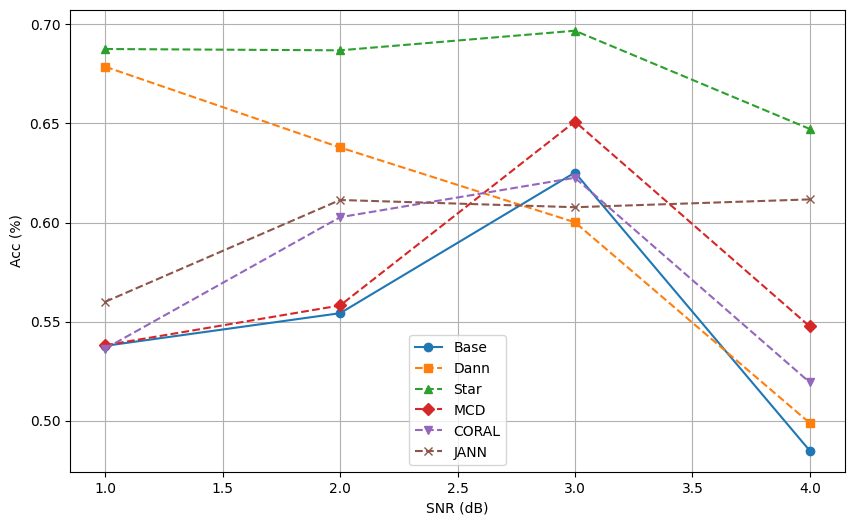

In [3]:
x = np.arange(1, n_snr+1)
print(len(t_base_acc))
print(len(x))

plt.figure(figsize=(10, 6))
plt.plot(x, t_base_acc, marker='o', linestyle='-', label='Base')
plt.plot(x, t_dann_acc, marker='s', linestyle='--', label='Dann')
plt.plot(x, t_star_acc, marker='^', linestyle='--', label='Star')
plt.plot(x, t_mcd_acc, marker='D', linestyle='--', label='MCD')
plt.plot(x, t_coral_acc, marker='v', linestyle='--', label='CORAL')
plt.plot(x, t_jan_acc, marker='x', linestyle='--', label='JANN')


plt.xlabel('SNR (dB)')
plt.ylabel('Acc (%)')
plt.legend()
plt.grid(True)
plt.show()